# Setup

In [30]:
# Extract and build the benchmark
def make_io_file():
    !make -C io

    !mkdir -p /data/lab1
    !io/io-static -c lab1/iofile

make_io_file()

Benchmark configuration:
  buffersize: 16384
  totalsize: 16777216
  blockcount: 1024
  operation: create
  path: lab1/iofile
  time: 2.461115000
speed: 6657.15 KBytes/sec


In [45]:
def strs_to_tup(strs):
    if len(strs) == 1:
        return (strs[0].strip(),None)
    else:
        return (strs[0].strip(),strs[1].strip())

def parse(cmd_out):
    tups = map(strs_to_tup, [string.split(":") for string in cmd_out])
    return dict(tups)

import time
from __future__ import print_function
from decimal import Decimal
import pandas as pd
import numpy as np
%matplotlib inline
# import matplotlib.pyplot as plt
# plt.style.use('seaborn-whitegrid')

def label_point(x, y, ax):
    a = pd.concat({'x': x, 'y': y}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'], point['y'], "{:.2E}".format(Decimal(point['x'])))

# np.array expects: [[x1, y1], [x2, y2], ..., [xn, yn]]
def graph(xs, ys, save = False, save_name = "plot"):
    df = pd.DataFrame(np.array(np.column_stack((xs, ys))), columns=['x', 'y'])
    plt = df.plot.scatter(x='x', y='y',logx=True, grid=True, figsize=(20,10))
    label_point(df.x, df.y, plt)
    if save:
        fig = plt.get_figure()
        fig.savefig("{}.pdf".format(save_name))

def benchmark(flags, repeat, exe, filename, buf_sizes, io_sizes, create = False, reset_file = False, dtrace_info = None ):
    runs = range(1, repeat + 1)
    outputs = []
    print("\t ==> Running {}".format(exe))
    print("\t\t ==> Reading from {}".format(filename))
    is_dtrace = (dtrace_info != None)
    dtrace_thread = None

    for buffer_size in buf_sizes:
        for io_size in io_sizes:
            cmd = "{} {} -b {} -t {} {}".format(exe, flags, buffer_size, io_size, filename)
            #if "-v" not in flags:
            #    cmd = "time -p " + cmd
            discard = !{cmd}

            if create:
                created = !io/io-static -t {str(io_size)} -c lab1/iofile

            if is_dtrace:
                # Create a seperate thread to run the DTrace instrumentation
                dtrace_thread = DTraceConsumerThread(dtrace_info['script'],
                                                        chew_func=None,
                                                        chewrec_func=None,
                                                        walk_func=dtrace_info['agg_fn'],
                                                        sleep=1)
                # Start the DTrace instrumentation
                dtrace_thread.start()

            results = []
            for i in runs:
                out = !{cmd}
                parsed = parse(out)
                results.append(parsed)

            if is_dtrace and dtrace_thread != None:
                # The benchmark has completed - stop the DTrace instrumentation
                dtrace_thread.stop()
                dtrace_thread.join()
                print("\t\t\tdtrace run: {0:2} bytes {1:2} bytes".format(buffer_size, io_size))
            else:
                times = [float(item['time']) for item in results]
                speeds = [float(item['speed'].split(' ')[0]) for item in results] # Need to split by ' ' because output speed has units attached to it (see io.c)
                avg_time = sum(times) / len(runs)
                avg_speed = sum(speeds) / len(runs)
                buf_sz = int(results[0]['buffersize'])
                tot_sz = int(results[0]['totalsize'])
                print("\t\t\t{0:2} bytes {1:2} bytes ({2:.2f} KBytes/sec): {3:.6f}s".format(buf_sz, tot_sz, avg_speed, avg_time))
                outputs.append({'buffersize':buffer_size, 'time':avg_time, 'speed':avg_speed, 'iosize':tot_sz})
    if reset_file:
        print("recreating default benchmark file")
        make_io_file()
    return outputs

In [46]:
# D Language scripts
D_ffs_read_time = """
syscall::clock_gettime:return
/execname == "io-static" && !self->in_benchmark/
{
    self->in_benchmark = 1;
}

syscall::clock_gettime:entry
/execname == "io-static" && self->in_benchmark/
{
    self->in_benchmark = 0;
}

fbt::ffs_read:entry
/self->in_benchmark/
{
    self->ts = vtimestamp;
}
fbt::ffs_read:return
/self->ts && self->in_benchmark/
{
    @[id] = sum(vtimestamp - self->ts);
    self->ts = 0;
}
"""

D_program_time = """
syscall::execve:return
/execname == "io-static" && self->ts/
{
    trace(vtimestamp - self->ts)
}

syscall::exit:entry
/execname == "io-static"/
{
    self->ts = vtimestamp;
}
"""

# Reads

## Constant IO/Varying Buffer (with cache, static/dynamic)

* Total size: 16MB (default)
* Buffer: varies from 512 to 512 * 2^16
* (io.c modified to output kbytes/sec in same format as other params)
* Run multiple times then average
* Prevent warmup effect

In [14]:
BUF_START = 512
BUFFER_SIZES = [BUF_START * 2 ** exp for exp in range(0, 16)]
IO_SIZES = [BUFFER_SIZES[-1]] # Keep constant at default 16MB (last value of BUFFER_SIZES)

results_iofile = benchmark("-v -r -d", 12, "io/io-static", "lab1/iofile", BUFFER_SIZES, IO_SIZES)
# results_zero = benchmark("-v -r", 10, "io/io-static", "/dev/zero")
# results_random = benchmark("-v -r", 10, "io/io-static", "/dev/random")

saveas = "static_maxra_64_const_io_flags_vrd_runs_12"
graph([item['buffersize'] for item in results_iofile], [item['speed'] for item in results_iofile], save = True, save_name = saveas)

	 ==> Running io/io-static
		 ==> Reading from lab1/iofile
^C


KeyboardInterrupt: 

### DTrace

#### TODO
* Probe effect measurement

In [ ]:
BUF_START = 512
BUFFER_SIZES = [BUF_START * 2 ** exp for exp in range(14, 16)]
IO_SIZES = [BUFFER_SIZES[-1]] # Keep constant at default 16MB (last value of BUFFER_SIZES)
RUNS = 12
values = []

# Callback invoked to process the aggregation
def simple_out(a, b, c, d):
    # print(a,b,c,d)
    values.append(d)

for io_sz in IO_SIZES:
    for buf_sz in BUFFER_SIZES:
        benchmark("-r", 12, "io/io-static", "lab1/iofile", [buf_sz], [io_sz], dtrace_info = {'agg_fn':simple_out, 'script':D_ffs_read_time})
        avg_time = sum(values) / RUNS
        avg_speed = (IO_SIZES[0]/1024)/(avg_time/1e9)
        print("Average time = {} nseconds".format(avg_time))
        print("Average bandwidth = {} KiBytes/sec".format(avg_speed))

## Buffer Size Constant/Vary IO

	 ==> Running io/io-static
		 ==> Reading from lab1/iofile
			16384 bytes 16384 bytes (3571.37 KBytes/sec): 0.004511s
			16384 bytes 32768 bytes (4037.20 KBytes/sec): 0.007968s
			16384 bytes 65536 bytes (4898.29 KBytes/sec): 0.013960s
			16384 bytes 131072 bytes (6727.28 KBytes/sec): 0.019315s
			16384 bytes 262144 bytes (7762.52 KBytes/sec): 0.033525s
			16384 bytes 524288 bytes (8303.61 KBytes/sec): 0.062798s
			16384 bytes 1048576 bytes (8479.34 KBytes/sec): 0.123251s
			16384 bytes 2097152 bytes (8272.88 KBytes/sec): 0.254252s
			16384 bytes 4194304 bytes (8532.39 KBytes/sec): 0.489175s
			16384 bytes 8388608 bytes (8386.19 KBytes/sec): 0.995026s
			16384 bytes 16777216 bytes (8209.72 KBytes/sec): 2.045753s
Saved plot at static_create_read_y_speed_maxra_64_const_buf_16kb_flags_vrd_runs_12


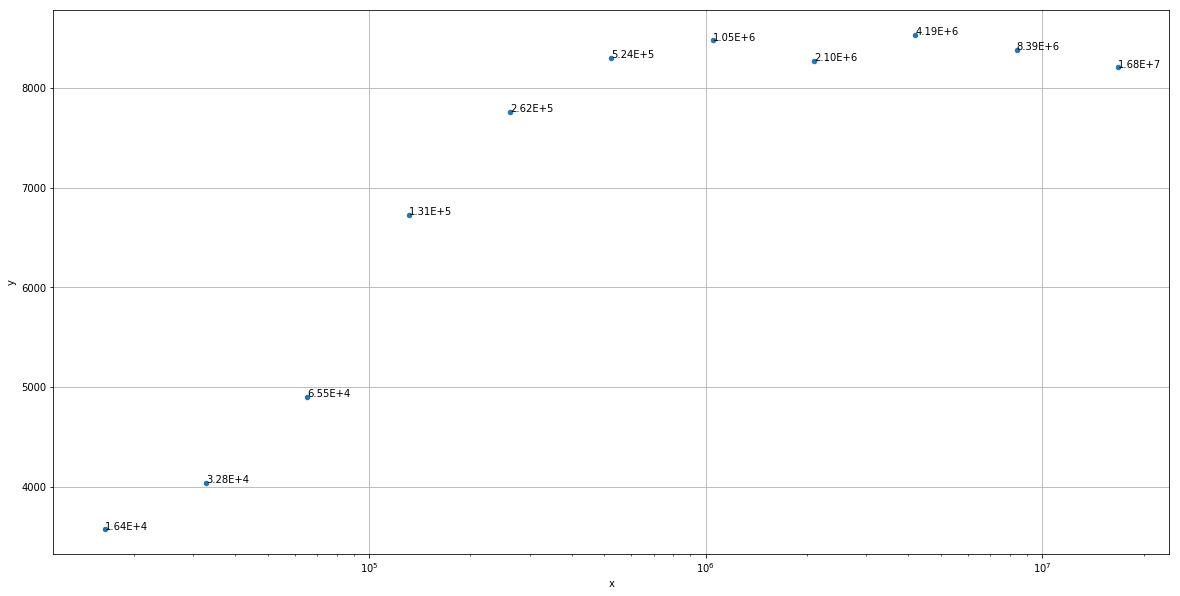

In [10]:
# Setup
IO_START = 512
IO_SIZES = [IO_START * 2 ** exp for exp in range(5, 16)]
BUFFER_SIZES = [512 * 2 ** 5] # Keep constant at default 16KB

results_iofile = benchmark("-v -r -d", 12, "io/io-static", "lab1/iofile", BUFFER_SIZES, IO_SIZES, create = True, reset_file = True)

saveas = "static_create_read_y_speed_maxra_64_const_buf_16kb_flags_vrd_runs_12"
graph([item['iosize'] for item in results_iofile], [item['speed'] for item in results_iofile], save = True, save_name = saveas)
print("Saved plot at {}".format(saveas))

# Write

In [ ]:
BUF_START = 512
BUFFER_SIZES = [BUF_START * 2 ** exp for exp in range(0, 16)]
IO_SIZES = [BUFFER_SIZES[-1]] # Keep constant at default 16MB (last value of BUFFER_SIZES)

results_iofile = benchmark("-v -w", 12, "io/io-static", "lab1/iofile", BUFFER_SIZES, IO_SIZES)

saveas = "static_write_y_speed_maxra_64_const_io_flags_vw_runs_12"
print("Saving plot at {}".format(saveas))
graph([item['buffersize'] for item in results_iofile], [item['speed'] for item in results_iofile], save = True, save_name = saveas)

	 ==> Running io/io-static
		 ==> Reading from lab1/iofile
^C
^C
^C
^C
Traceback (most recent call last):
  File "/usr/local/lib/python2.7/site-packages/IPython/core/ultratb.py", line 970, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/python2.7/site-packages/IPython/core/ultratb.py", line 233, in wrapped
    return f(*args, **kwargs)
  File "/usr/local/lib/python2.7/site-packages/IPython/core/ultratb.py", line 267, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/usr/local/lib/python2.7/inspect.py", line 1048, in getinnerframes
    framelist.append((tb.tb_frame,) + getframeinfo(tb, context))
  File "/usr/local/lib/python2.7/inspect.py", line 1008, in getframeinfo
    filename = getsourcefile(frame) or getfile(frame)
  File "/usr/local/lib/python2.7/inspect.py", line 453, in getsourcefile
    if hasattr(getmodule(object, filename), '__loader__'):
  File "

ERROR: Internal Python error in the inspect module.
Below is the traceback from this internal error.


Unfortunately, your original traceback can not be constructed.



Traceback (most recent call last):
  File "/usr/local/lib/python2.7/site-packages/IPython/core/ultratb.py", line 970, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/python2.7/site-packages/IPython/core/ultratb.py", line 233, in wrapped
    return f(*args, **kwargs)
  File "/usr/local/lib/python2.7/site-packages/IPython/core/ultratb.py", line 285, in _fixed_getinnerframes
    lines = ulinecache.getlines(file)[start:end]
  File "/usr/local/lib/python2.7/site-packages/IPython/utils/ulinecache.py", line 37, in getlines
    return [l.decode(encoding, 'replace') for l in lines]
  File "/usr/local/lib/python2.7/encodings/utf_8.py", line 16, in decode
    return codecs.utf_8_decode(input, errors, True)
KeyboardInterrupt


ERROR: Internal Python error in the inspect module.
Below is the traceback from this internal error.


Unfortunately, your original traceback can not be constructed.



In [15]:
IO_START = 512
IO_SIZES = [IO_START * 2 ** exp for exp in range(5, 16)]
BUFFER_SIZES = [512 * 2 ** 5] # Keep constant at default 16KB

results_iofile = benchmark("-v -w", 12, "io/io-static", "lab1/iofile", BUFFER_SIZES, IO_SIZES, create = True, reset_file = True)

saveas = "static_create_write_y_speed_maxra_64_const_buf_16kb_flags_vw_runs_12"
print("Saving plot at {}".format(saveas))
graph([item['iosize'] for item in results_iofile], [item['speed'] for item in results_iofile], save = True, save_name = saveas)

	 ==> Running io/io-static
		 ==> Reading from lab1/iofile
ERROR! Session/line number was not unique in database. History logging moved to new session 124
^C
^C
^C
^C


KeyError: 'time'